# <center>爬取百度地图全国地铁线路信息</center>

In [1]:
import requests
import time
from queue import Queue
from threading import Thread
from collections import defaultdict
import json
import os

In [2]:
class SubwayParse(Thread):
    header = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.142 Safari/537.36'
    }
    def __init__(self, city_queue, api='http://map.baidu.com/?qt=bsi&c={}&t={}', *args, **kwargs):
        self.city_queue = city_queue
        self.api = api
        super().__init__(*args, **kwargs)
        if not os.path.exists('subways'):
            os.mkdir('subways')
        
    @classmethod
    def get_city_queue(cls, api, queue_len=10000):
        """获取城市信息"""
        citys_queue = Queue(queue_len)
        response = requests.get(api.format(int(time.time()*1000)), headers = cls.header)
        citys = response.json()['subways_city']['cities']
        for city in citys:
            if citys_queue.full():
                continue
            citys_queue.put(city)
        return citys_queue
    
    def get_subway_info(self, city_info):
        """根据获取的城市信息，获取此城市的地铁线路信息"""
        city_code = city_info['code']
        city_name = city_info['cn_name']
        response = requests.get(self.api.format(city_code, int(time.time()*1000)), headers = self.header)
        subway_info = response.json()
        return {city_name: subway_info['content']}
    
    def parse_subway_info(self, subway_info):
        """解析获取的地铁信息，并进行格式化为需要的数据结构"""
        city_name, subway_info = list(subway_info.items())[0]
        parsed_stations = defaultdict(list)
        parsed_lines = defaultdict(list)
        parsed_connection = defaultdict(list)
        for line in subway_info:
            line_name = line['line_name']
            stations = line['stops']
            for i, station in enumerate(stations):
                station_name = station['name']
                station_coord = (station['x'], station['y'])
                parsed_stations[station_name] = station_coord
                parsed_lines[line_name].append(station_name)
                if i == 0:
                    next_station = stations[i+1]['name']
                    front_station = None
                elif i == len(stations) - 1 and i > 0:
                    next_station = None
                    front_station = stations[i-1]['name']
                else:
                    next_station = stations[i+1]['name']
                    front_station = stations[i-1]['name']
                    if (next_station is not None) and (next_station not in parsed_connection[station_name]):
                        parsed_connection[station_name].append(next_station)
                    if (front_station is not None) and (front_station not in parsed_connection[station_name]):
                        parsed_connection[station_name].append(front_station)
        return {
            'city': city_name,
            'stations': parsed_stations,
            'lines': parsed_lines,
            'connection': parsed_connection,
        }
    
    def run(self):
        """重写 Thread 类 run 方法"""
        while True:
            if self.city_queue.empty():
                print('线程 %s 已完成信息获取!' % (self.name))
                break
            try:
                city_info = self.city_queue.get()
                subway_info = self.get_subway_info(city_info)
                parsed_info = self.parse_subway_info(subway_info)
                city_name = parsed_info['city']
                with open(os.path.join('subways', city_name + '.json'), 'w', encoding='utf-8') as fp:
                    json.dump(parsed_info, fp)
                    print('已经获取地铁信息 -> %s' % city_name)
            except:
                pass
            
            
            
            

In [3]:
# 获取地铁城市队列
city_queue = SubwayParse.get_city_queue('https://map.baidu.com/?qt=subwayscity&t={}')

In [4]:
# 创建5个线程，进行各个城市地铁信息爬取
for i in range(5):
    SubwayParse(city_queue).start()

已经获取地铁信息 -> 深圳市
已经获取地铁信息 -> 广州市
已经获取地铁信息 -> 天津市
已经获取地铁信息 -> 北京市
已经获取地铁信息 -> 上海市
已经获取地铁信息 -> 石家庄市
已经获取地铁信息 -> 重庆市
已经获取地铁信息 -> 南京市
已经获取地铁信息 -> 沈阳市
已经获取地铁信息 -> 成都市
已经获取地铁信息 -> 武汉市
已经获取地铁信息 -> 杭州市
已经获取地铁信息 -> 长沙市
已经获取地铁信息 -> 苏州市
已经获取地铁信息 -> 昆明市
已经获取地铁信息 -> 长春市
已经获取地铁信息 -> 大连市
已经获取地铁信息 -> 西安市
已经获取地铁信息 -> 佛山市
已经获取地铁信息 -> 郑州市
已经获取地铁信息 -> 无锡市
已经获取地铁信息 -> 哈尔滨市
已经获取地铁信息 -> 温州市
已经获取地铁信息 -> 宁波市
已经获取地铁信息 -> 青岛市
已经获取地铁信息 -> 南昌市
已经获取地铁信息 -> 济南市
已经获取地铁信息 -> 东莞市
已经获取地铁信息 -> 福州市
已经获取地铁信息 -> 合肥市
已经获取地铁信息 -> 南宁市
已经获取地铁信息 -> 乌鲁木齐市
已经获取地铁信息 -> 厦门市
已经获取地铁信息 -> 贵阳市
已经获取地铁信息 -> 兰州市
线程 Thread-10 已完成信息获取!
线程 Thread-6 已完成信息获取!
线程 Thread-7 已完成信息获取!
线程 Thread-8 已完成信息获取!
线程 Thread-9 已完成信息获取!


# <center>数据测试</center>

In [5]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

In [6]:
def city_subway_info(city):
    path = os.path.join('subways', city + '.json')
    if not os.path.exists(path):
        print('此城市信息不存在！存在信息的城市如下：')
        print('-'*50)
        print([x.replace('.json', '') for x in os.listdir('subways')])
        return None
    with open(path, 'r') as fp:
        return json.load(fp)
    
def view_connection(info):
    stations, lines, connection = list(info.values())[1:]
    graph = nx.Graph(info['connection'])
    plt.figure(figsize=(30,20))
    nx.draw(graph, stations, with_labels=True, node_size=30)
    plt.show()

In [7]:
beijing = city_subway_info('北京')
beijing

此城市信息不存在！存在信息的城市如下：
--------------------------------------------------
['上海市', '东莞市', '乌鲁木齐市', '佛山市', '兰州市', '北京市', '南京市', '南宁市', '南昌市', '厦门市', '合肥市', '哈尔滨市', '大连市', '天津市', '宁波市', '广州市', '成都市', '无锡市', '昆明市', '杭州市', '武汉市', '沈阳市', '济南市', '深圳市', '温州市', '石家庄市', '福州市', '苏州市', '西安市', '贵阳市', '郑州市', '重庆市', '长春市', '长沙市', '青岛市']


In [8]:
beijing = city_subway_info('北京市')
beijing

{'city': '北京市',
 'stations': {'西苑': [12946436.16, 4838955.12],
  '农大南路': [12945339.98, 4842246.84],
  '马连洼': [12944288.92, 4843831.98],
  '西北旺': [12942598.82, 4846225.97],
  '永丰南': [12941544.91, 4848597.84],
  '永丰': [12940448.93, 4849463.65],
  '屯佃': [12937963.89, 4848950.92],
  '稻香湖路': [12934881.53, 4849049.7],
  '温阳路': [12931883.88, 4849064.79],
  '北安河': [12928432.87, 4848915.76],
  '石厂': [12925109.93, 4823052.84],
  '小园': [12926671.39, 4823200.13],
  '栗园庄': [12927653.92, 4824011.63],
  '上岸': [12927529.93, 4825365.7],
  '桥户营': [12927925.91, 4826408.8],
  '四道桥': [12928825.93, 4826952.88],
  '金安桥': [12932010.92, 4828088.16],
  '阎村东': [12925112.98, 4799894.97],
  '紫草坞': [12923584.98, 4799254.97],
  '阎村': [12922864.9, 4798133.01],
  '星城': [12920745.91, 4797736.72],
  '大石河东': [12918331.49, 4797215.05],
  '马各庄': [12915767.86, 4796500.01],
  '饶乐府': [12914604.91, 4795950.84],
  '房山城关': [12912784.92, 4796576.67],
  '燕山': [12910991.95, 4798525.09],
  '香山': [12936702.8, 4838193.09],
  '植物园': [1

C:\python\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


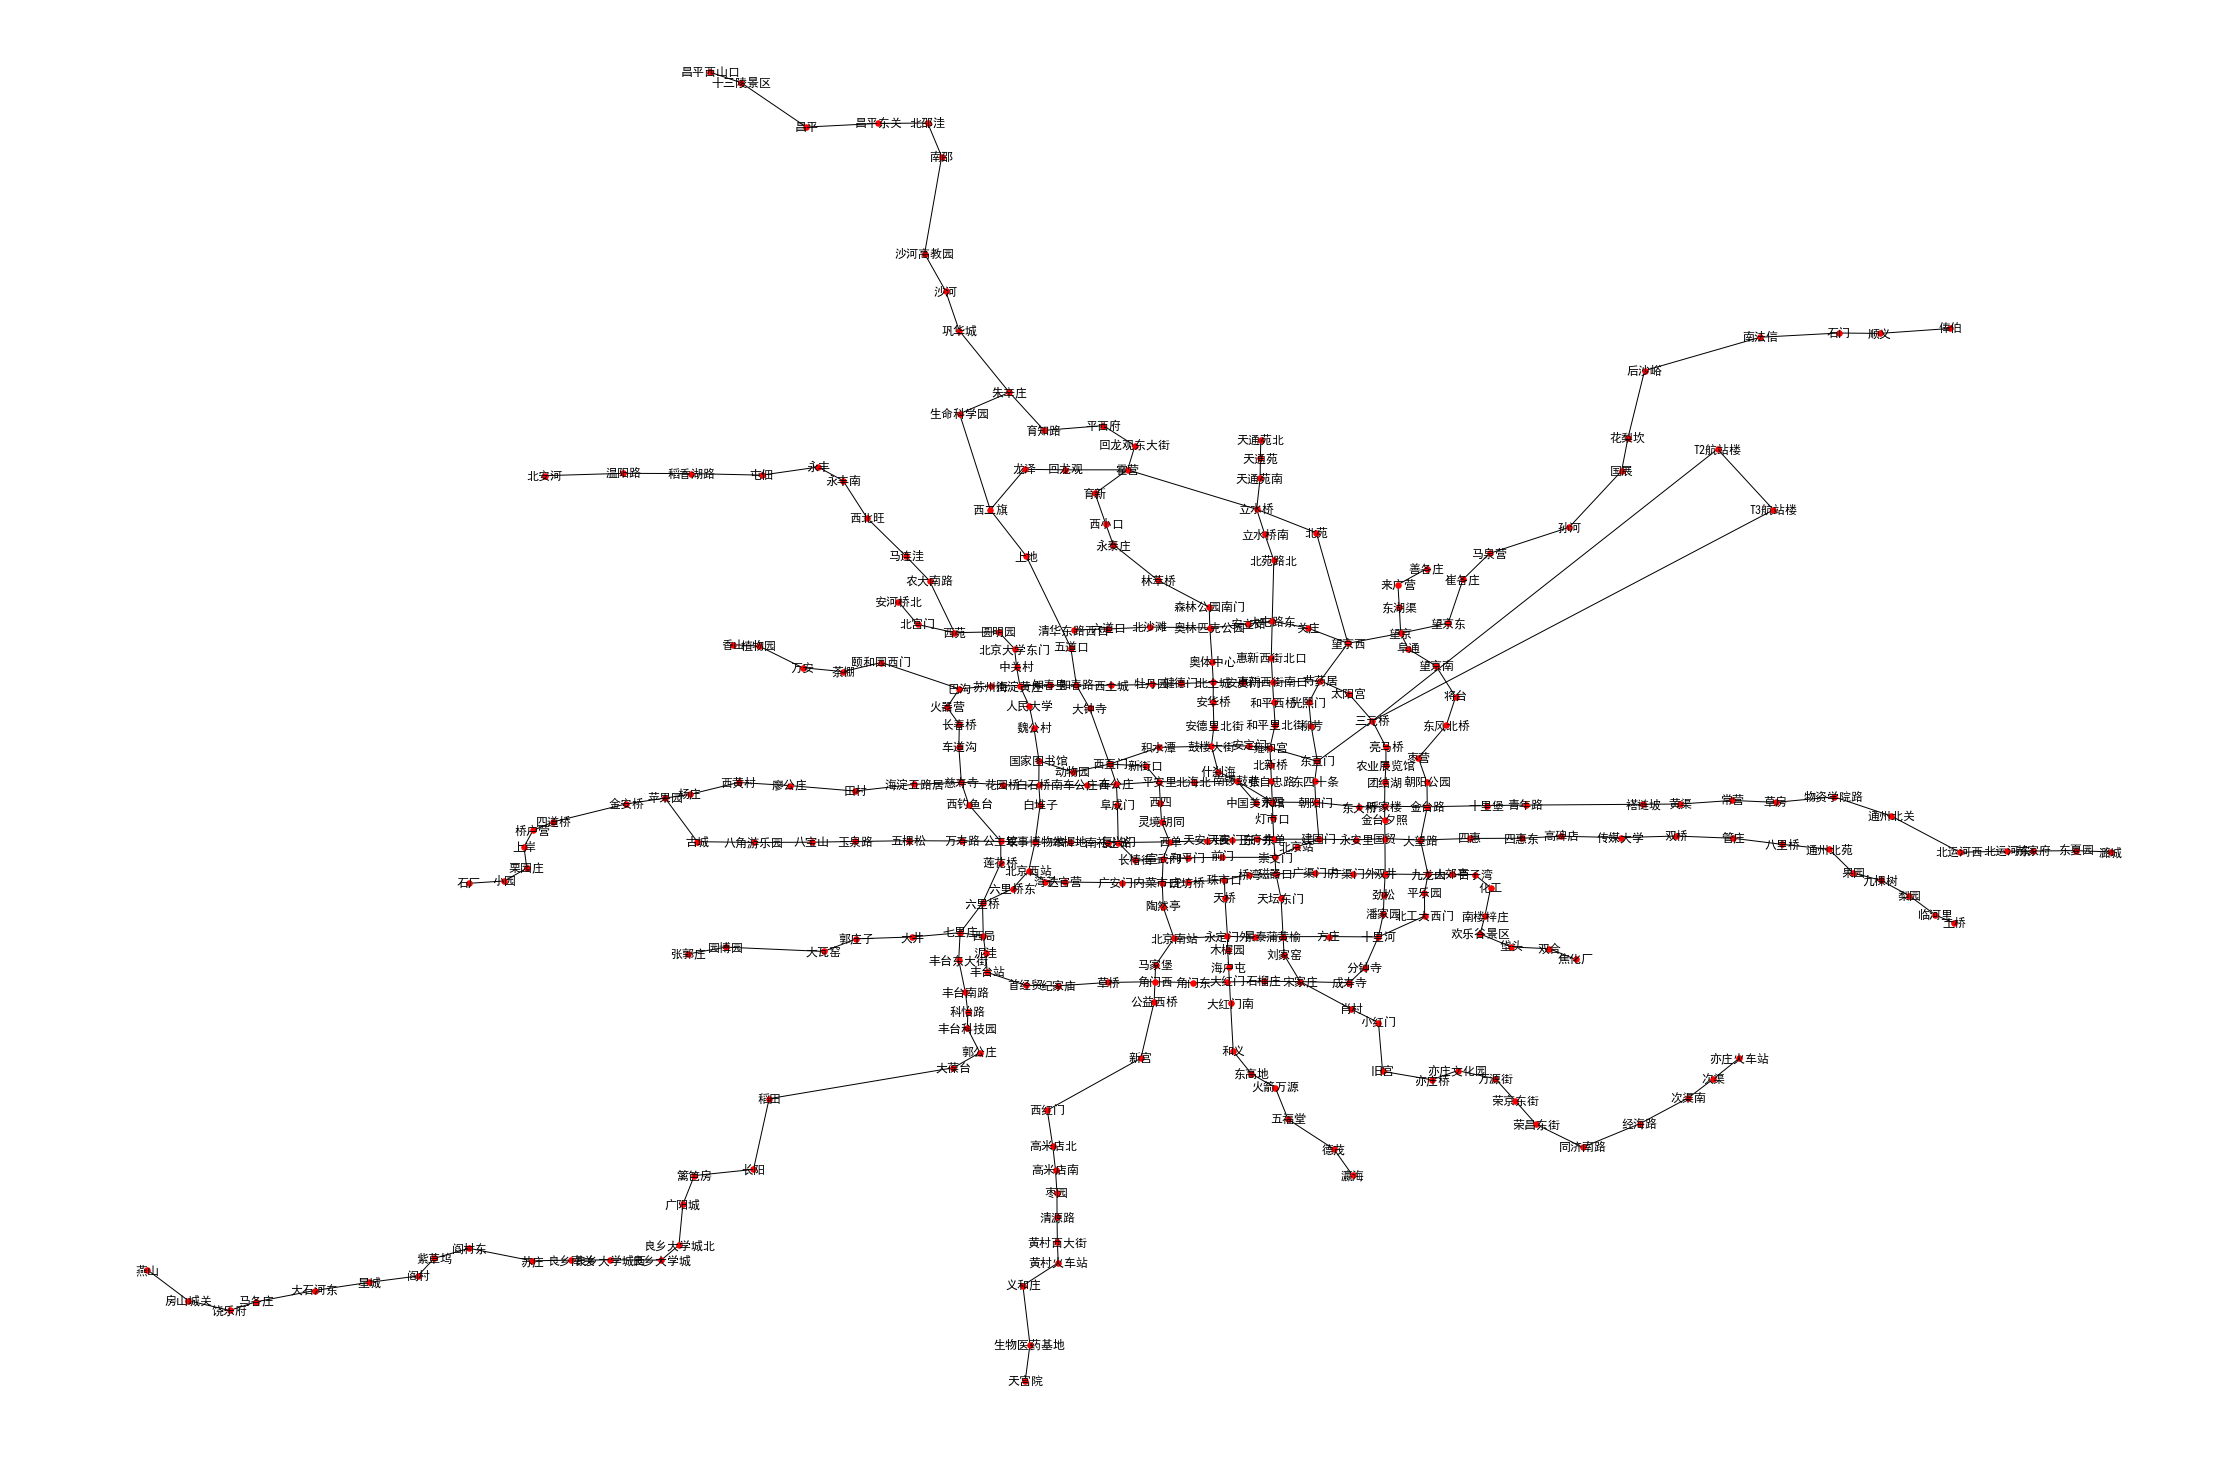

In [9]:
view_connection(beijing)

In [10]:
zhengzhou = city_subway_info('郑州市')
zhengzhou

{'city': '郑州市',
 'stations': {'月季公园': [12649287.82, 4108327.27],
  '沙口路': [12651308.1, 4109024.19],
  '海滩寺': [12652327.99, 4109478.37],
  '郑州人民医院': [12654232.53, 4109513.58],
  '黄河路': [12655896.94, 4109483.81],
  '省人民医院': [12657068.75, 4109466.59],
  '姚砦': [12658817.92, 4109446.76],
  '众意西路': [12659993.3, 4109698.53],
  '中央商务区': [12661410.33, 4109966.15],
  '儿童医院': [12663524.35, 4109902.34],
  '祭城': [12665309.63, 4109835.82],
  '金水东路': [12665788.81, 4108845.31],
  '郑州东站': [12666225.03, 4107454.86],
  '康宁街': [12666099.79, 4106243.22],
  '省骨科医院': [12666145.84, 4105472.68],
  '经开中心广场': [12665078.39, 4102312.69],
  '福塔东': [12663120.34, 4102313.08],
  '中原福塔': [12661479.38, 4102279.94],
  '七里河': [12660398.38, 4102251.94],
  '航海广场': [12658579.72, 4102223.84],
  '城东南路': [12656834.91, 4102217.58],
  '南五里堡': [12655973.65, 4102175.18],
  '冯庄': [12654361.25, 4102203.2],
  '京广南路': [12653112.7, 4102221.87],
  '市第二人民医院': [12651657.16, 4102259.83],
  '齐礼阎': [12649908.71, 4102207.1],
  '后河芦': [12648923

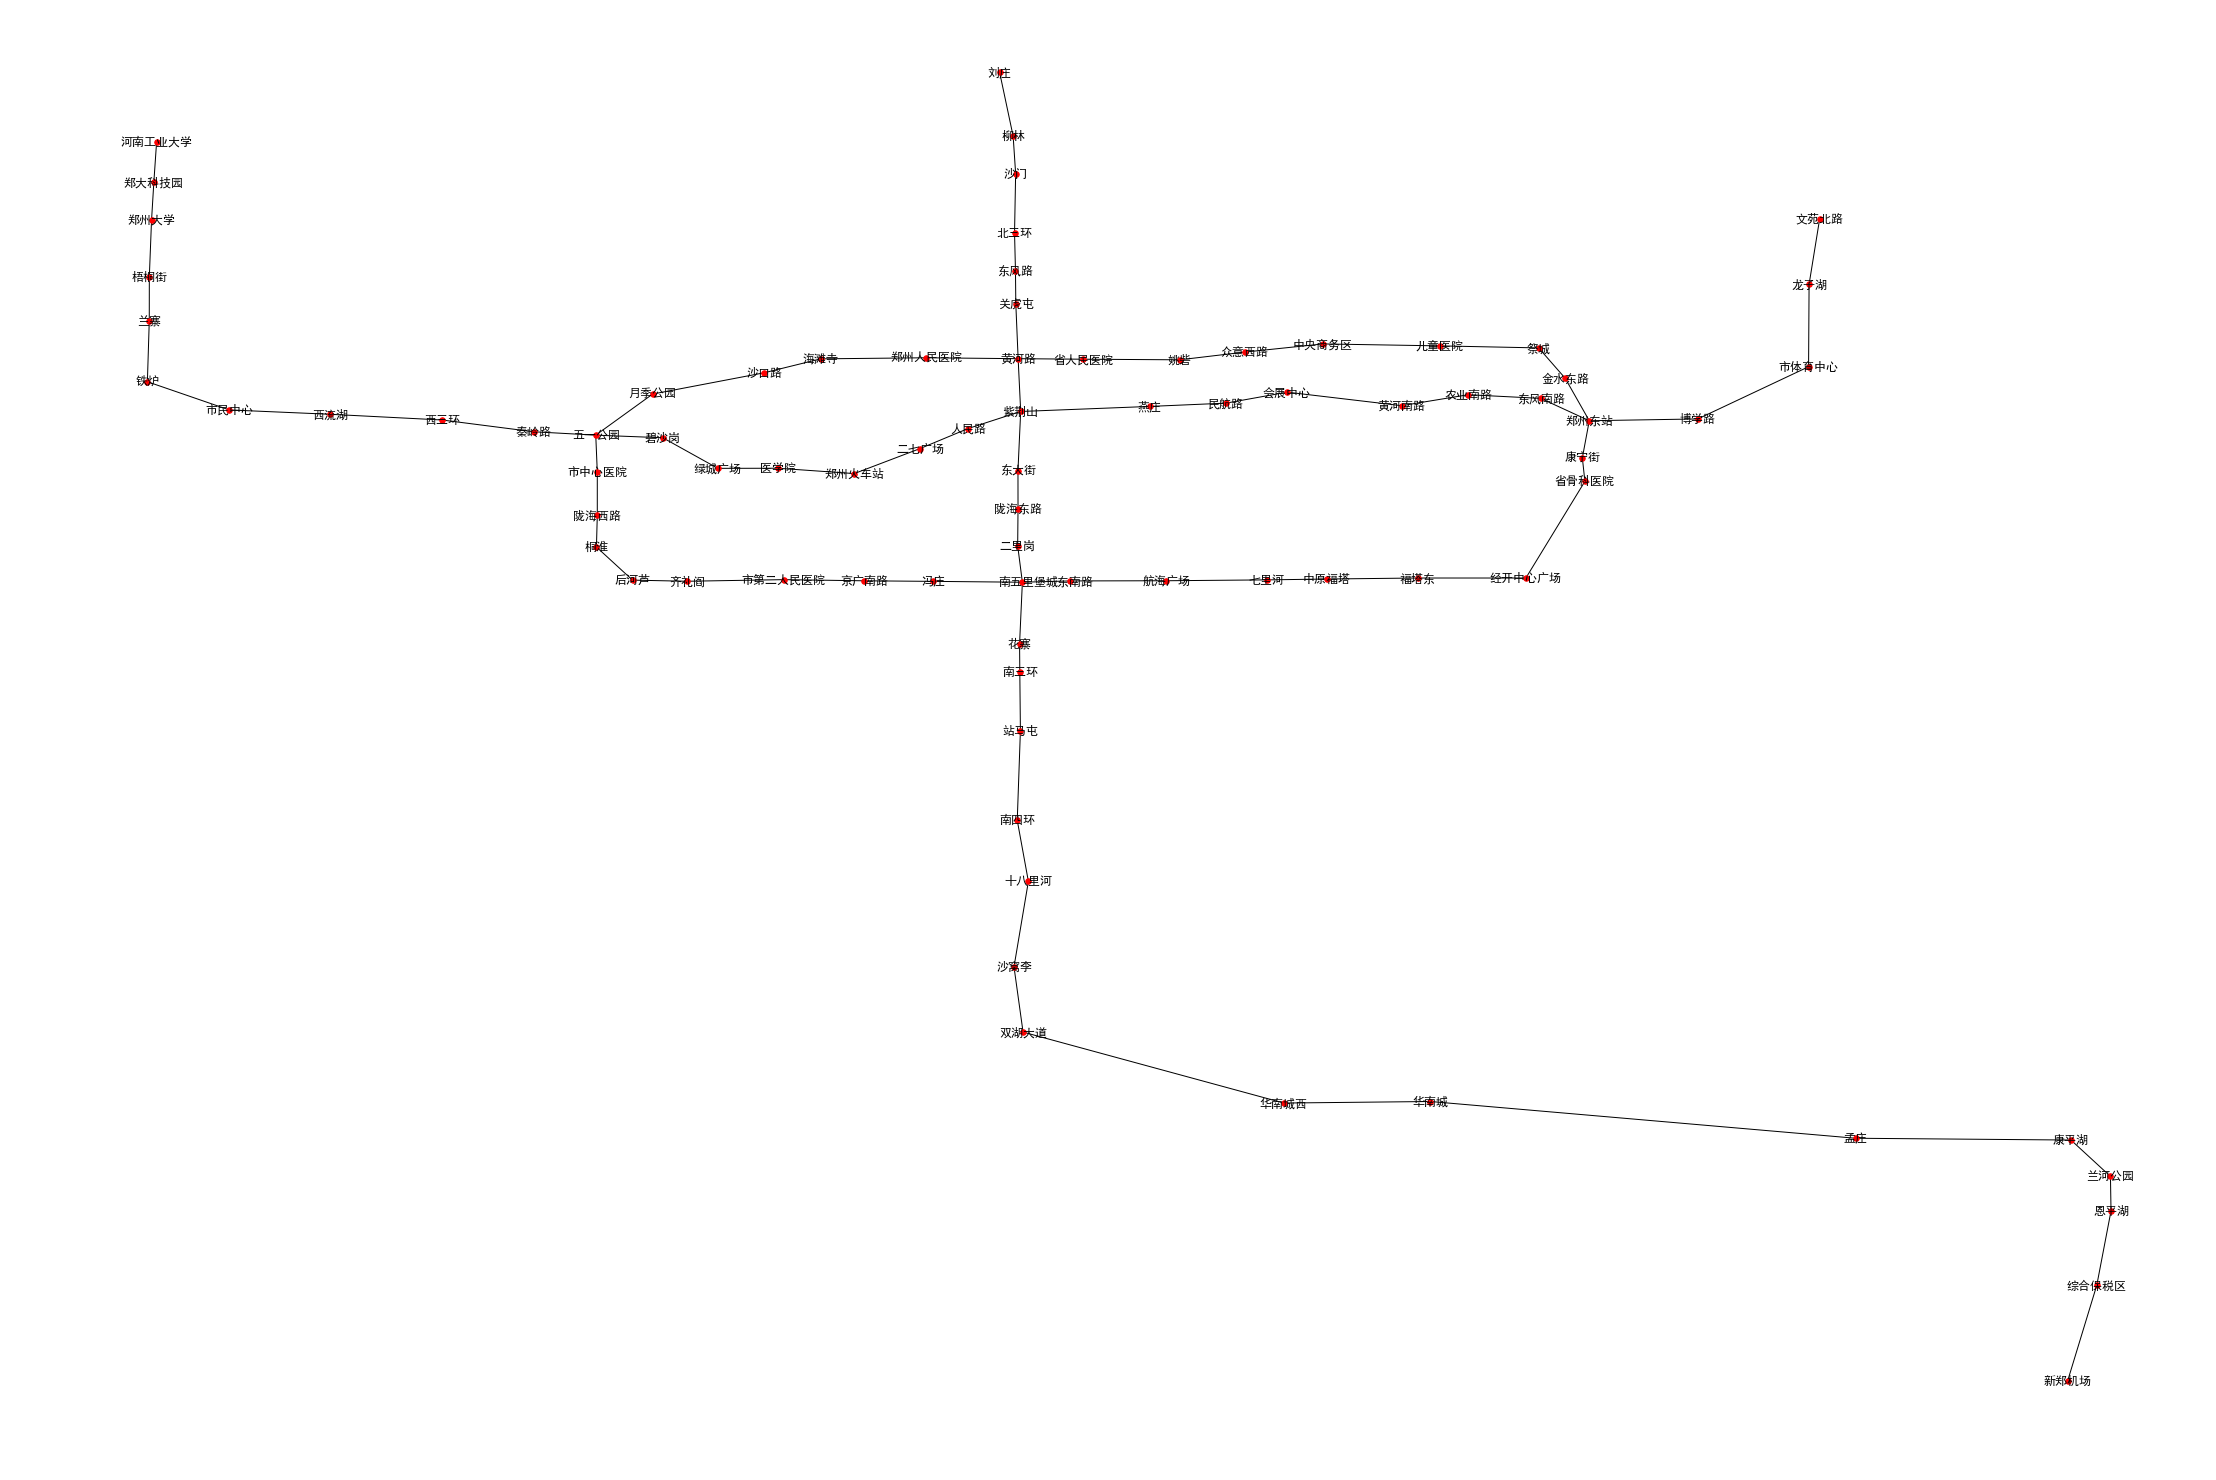

In [11]:
view_connection(zhengzhou)